In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

def read_data(filename):
	with open(filename) as f:
		s = f.read()

	return np.fromstring(s, sep=' ')

---
# Exercise 1: Direct PCA method

In [38]:
def pca(X): # column vectors
	N = X.shape[1]
	m = X.shape[0]
	mu = X.mean(axis=1).reshape((m, 1))
	Xd = X - mu
	C = Xd @ Xd.T / (N - 1)
	[U, S, Vt] = np.linalg.svd(C)
	return U, np.diag(S), Vt.T, mu, C

def projectToPCA(x, U, mu):
	return U.T @ (x - mu)

def projectFromPCA(y, U, mu):
	return U @ y + mu

In [39]:
import a6_utils

In [40]:
X = read_data("./data/points.txt")
X = np.reshape(X, (int(X.shape[0]/2), 2)).T

In [41]:
U, S, V, mu, C = pca(X)

(-5.566690035885173, 6.550794763613578, -1.262270922744718, 4.250584329654511)

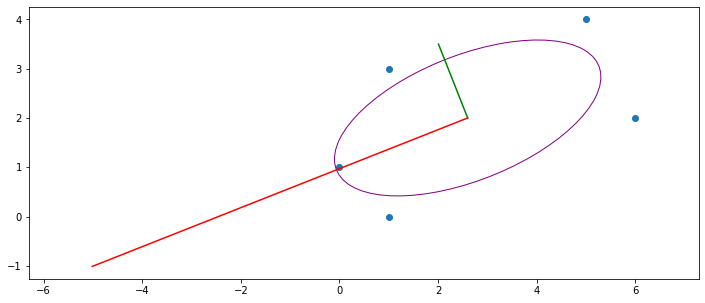

In [42]:
plt.scatter(X[0], X[1])
a6_utils.drawEllipse(mu, C)
plt.plot((mu[0], S[0,0]*U[0, 0] + mu[0]), (mu[1], S[0,0]*U[1, 0] + mu[1]), "r")
plt.plot((mu[0], S[1,1]*U[0, 1] + mu[0]), (mu[1], S[1,1]*U[1, 1] + mu[1]), "g")
plt.axis("equal")

They are aligned with the distribution of data, perpendicular to each other. They change if points are added/changed.

83.6%


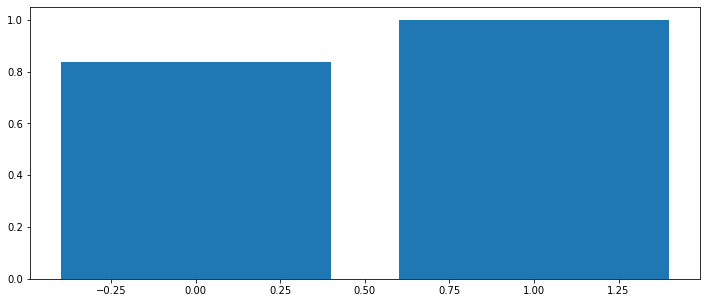

In [43]:
s = np.diag(S)
sc = np.cumsum(s)
sc /= sc[-1]
plt.bar(np.arange(sc.shape[0]), sc)
print("{:.3}%".format(100*sc[0]))

In [44]:
Xp = projectToPCA(X, U, mu)
Xp[1] = 0
Xrp = projectFromPCA(Xp, U, mu)

(-5.566690035885173, 6.550794763613579, -1.262270922744718, 4.250584329654511)

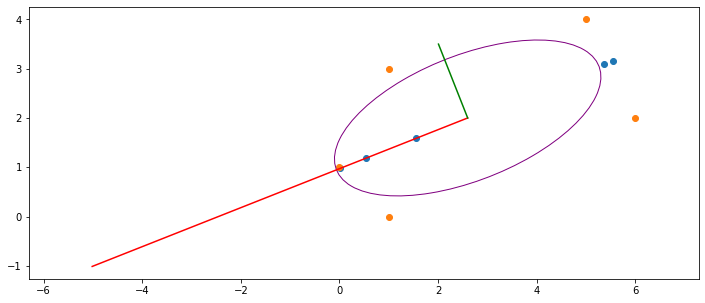

In [45]:
plt.scatter(Xrp[0], Xrp[1])
plt.scatter(X[0], X[1])
a6_utils.drawEllipse(mu, C)
plt.plot((mu[0], S[0,0]*U[0, 0] + mu[0]), (mu[1], S[0,0]*U[1, 0] + mu[1]), "r")
plt.plot((mu[0], S[1,1]*U[0, 1] + mu[0]), (mu[1], S[1,1]*U[1, 1] + mu[1]), "g")
plt.axis("equal")

Reconstructed points all lie on the subspace (line) spanned by the first eigenvector

In [46]:
qp = np.array([[3, 6]]).T
dists = np.sqrt(np.sum((X - qp)**2, axis=0))
print(dists)
print(dists.argmin())

[6.32455532 5.         2.82842712 3.60555128 5.83095189]
2


In [47]:
qpp = projectToPCA(qp, U, mu)
qpp[1] = 0
qprp = projectFromPCA(qpp, U, mu)

In [48]:
dists = np.sqrt(np.sum((Xrp - qprp)**2, axis=0))
print(dists)
print(dists.argmin())

[4.06628802 1.31883518 1.12438227 2.96307336 4.62847916]
2


(-5.566690035885173, 6.550794763613579, -1.362270922744718, 6.350584329654512)

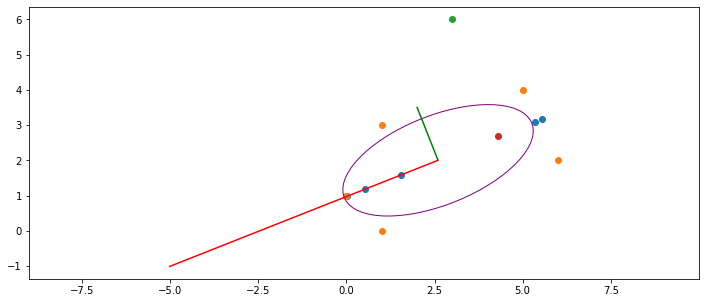

In [49]:
plt.scatter(Xrp[0], Xrp[1])
plt.scatter(X[0], X[1])
plt.scatter(qp[0], qp[1])
plt.scatter(qprp[0], qprp[1])
a6_utils.drawEllipse(mu, C)
plt.plot((mu[0], S[0,0]*U[0, 0] + mu[0]), (mu[1], S[0,0]*U[1, 0] + mu[1]), "r")
plt.plot((mu[0], S[1,1]*U[0, 1] + mu[0]), (mu[1], S[1,1]*U[1, 1] + mu[1]), "g")
plt.axis("equal")

---
# Exercise 2: The dual PCA method

In [50]:
def dual_pca(X): # column vectors
	N = X.shape[1]
	m = X.shape[0]
	mu = X.mean(axis=1).reshape((m, 1))
	Xd = X - mu
	C = Xd.T @ Xd / (m - 1)
	[U, S, Vt] = np.linalg.svd(C)
	Up = Xd @ U @ np.diag(np.sqrt(1/((S+1e-15) * (m - 1))))
	return Up, np.diag(S), Vt.T, mu, C

In [51]:
Ud, _,_,_,_ = dual_pca(X)

In [52]:
Ud[:,:2]

array([[ 0.92992935, -0.36773822],
       [ 0.36773822,  0.92992935]])

In [53]:
U

array([[-0.92992935, -0.36773822],
       [-0.36773822,  0.92992935]])

In [54]:
Xpd = projectToPCA(X, Ud, mu)
Xrpd = projectFromPCA(Xpd, Ud, mu)

In [55]:
np.mean((Xrpd - X)**2)

2.662405555120915e-31

---
# Exercise 3: Image decomposition examples

In [130]:
def img_to_vec(img):
	return img.reshape(-1)
def vec_to_img(vec, shape):
	return vec.reshape(shape)

def load_imgs(path):
	X = None
	shape = []
	for i in range(1, 64+1):
		filename = os.path.join(path, "{:03}.png".format(i))
		I = cv2.imread(filename)
		I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype(float)
		vec = img_to_vec(I)
		shape = I.shape
		if X is None:
			X = np.zeros((vec.shape[0], 64))
		X[:, i-1] = vec
	return X, shape
		

In [131]:
def img_pca(imgs):
	U, S, V, mu, C = dual_pca(imgs)
	return U, mu

In [139]:
X, shape = load_imgs("./data/faces/1")

In [140]:
U, mu = img_pca(X)

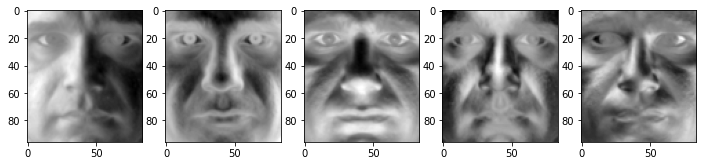

In [141]:
plt.rcParams["figure.figsize"] = (12,5)
for i in range(5):
	x = U[:, i]
	img = vec_to_img(x, shape)
	plt.subplot(1, 5, i+1)
	plt.imshow(img, cmap="gray")
plt.show()

They represent largest variance in images, eg. first one mostly light direction from left other right side. They show different features

In [142]:
xp = projectToPCA(X[:,:1], U, mu)
xrp = projectFromPCA(xp, U, mu)

In [143]:
np.mean((X[:,:1] - xrp) ** 2)

2.2302926983343487e-24

Reprojection is the same

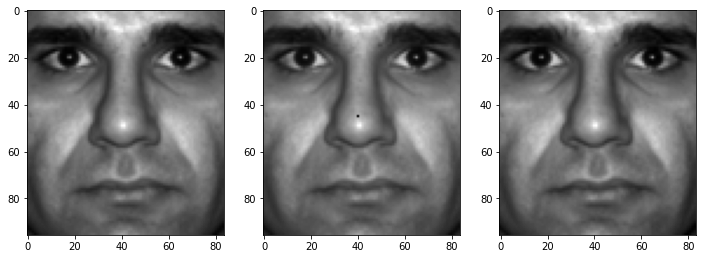

In [153]:
plt.subplot(131)
x = vec_to_img(X[:,:1], shape)
plt.imshow(x, cmap="gray")

plt.subplot(132)
xx = x.copy()
xx[45, 40] = 0
plt.imshow(xx, cmap="gray")

plt.subplot(133)
xp = projectToPCA(X[:,:1], U, mu)
xp[0] = 0
xrp = projectFromPCA(xp, U, mu)
xrp = vec_to_img(xrp, shape)
plt.imshow(xrp, cmap="gray")

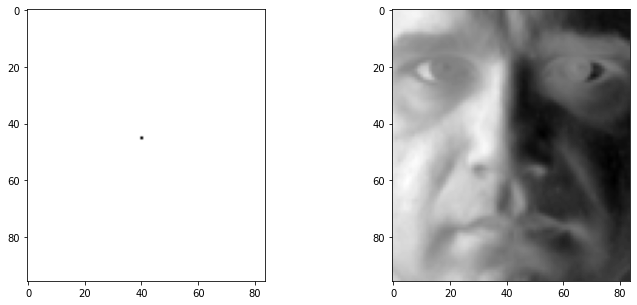

In [154]:
plt.subplot(121)
plt.imshow(xx - x, cmap="gray")

plt.subplot(122)
plt.imshow(xrp - x, cmap="gray")


First op. only changes one pixel, the second all (too some degree)

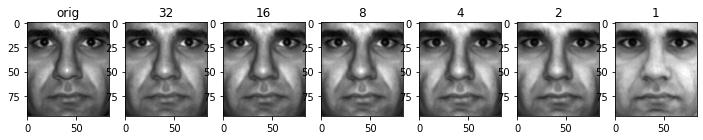

In [160]:
x = vec_to_img(X[:,:1], shape)
xp = projectToPCA(X[:,:1], U, mu)

plt.subplot(1, 7, 1)
plt.title("orig")
xx = vec_to_img(x, shape)
plt.imshow(xx, cmap="gray")

for i in range(5, -1, -1):
	plt.subplot(1, 7, 7-i)
	xpp = np.zeros_like(xp)
	xpp[:2**i] = xp[:2**i]
	plt.title(2**i)
	xrp = projectFromPCA(xpp, U, mu)
	xrp = vec_to_img(xrp, shape)
	plt.imshow(xrp, cmap="gray")

The more components are kept, the more similar the reconstruction is to the original

---
## BONUS

In [161]:
X, shape = load_imgs("./data/faces/1")
U, mu = img_pca(X)

In [172]:
I = cv2.imread("./data/elephant.jpg")
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype(float)
vec = img_to_vec(I)
vec = vec.reshape((-1, 1))

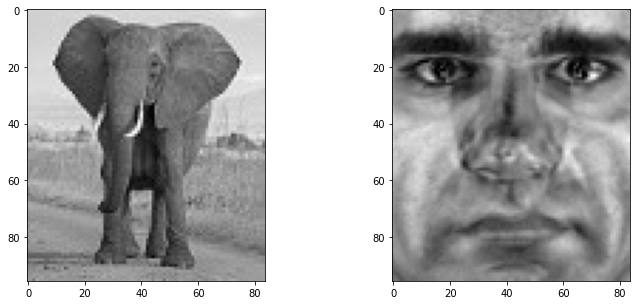

In [174]:
xp = projectToPCA(vec, U, mu)
xrp = projectFromPCA(xp, U, mu)
xrp = vec_to_img(xrp, shape)
plt.subplot(121)
plt.imshow(I, cmap="gray")

plt.subplot(122)
plt.imshow(xrp.clip(0, 255), cmap="gray")

In [199]:
def pca_comp_info(k, scale, x, double=False, k2=0):	
	xp = projectToPCA(mu, U, mu)
	xp = np.tile(xp, (1, len(x)))
	xp[k] = np.sin(x) * scale
	if double:
		xp[k2] = np.cos(x) * scale
	xrp = projectFromPCA(xp, U, mu)
	return xrp

def pca_comp_info_range(k, n, fro=-10 ,to=10, scale=3000, double=False, k2=0):
	x = np.linspace(fro, to, n)
	xrp = pca_comp_info(k, scale, x, double, k2)
	xs = []
	for i in range(n):
		xs.append(vec_to_img(xrp[:, i], shape))
	return xs

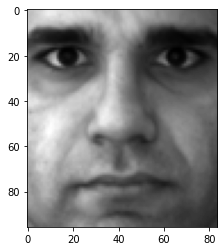

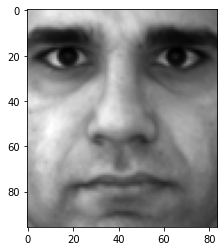

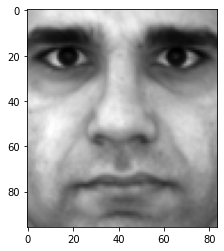

KeyboardInterrupt: 

In [228]:
n = 100
xrp = pca_comp_info_range(0, n)
plt.pause(0.5)
for i in range(n):
	plt.imshow(xrp[i], cmap="gray")
	plt.draw()
	plt.pause(0.1)
	

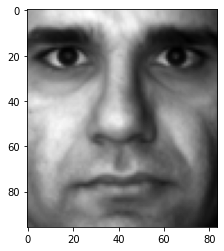

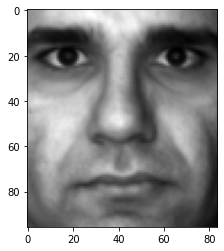

KeyboardInterrupt: 

In [225]:
n = 100
xrp = pca_comp_info_range(0, n, double=True, k2=1)
plt.pause(0.5)
for i in range(n):
	plt.imshow(xrp[i], cmap="gray")
	plt.draw()
	plt.pause(0.1)
	

In [312]:
def lda(Xs, Upca, Spca, mupca):
	s = np.diag(Spca)
	non0 = np.count_nonzero(np.abs(np.diag(Spca)) > 1e-9)
	for i in range(len(Xs)):
		Xs[i] = projectToPCA(Xs[i], Upca, mupca)[:non0, :]

	m = Xs[0].shape[0]
	mus = np.zeros((m, len(Xs)))
	Ns = np.zeros((len(Xs)))
	Sw = np.zeros((m, m))
	for i, X in enumerate(Xs):
		N = X.shape[1]
		Ns[i] = N
		mu = X.mean(axis=1).reshape((m, 1))
		mus[:, i:i+1] = mu
		
		Xd = X - mu
		Sw += Xd @ Xd.T

	mu = mus.mean(axis=1).reshape((m, 1))
	Sb = (mus - mu) @ np.diag(Ns) @ (mus - mu).T
	[U, S, Vt] = np.linalg.svd(np.linalg.inv(Sw) @ Sb)
	return Upca[:, :non0] @ U, S, V.T

In [313]:
X1, shape = load_imgs("./data/faces/1")
X2, shape = load_imgs("./data/faces/2")
X3, shape = load_imgs("./data/faces/3")
X1 = X1
X2 = X2
X2 = X2
Xs = np.hstack((X1, X2, X3))
Xss = [X1, X2, X3]
U, S, V, mu, C = dual_pca(Xs)

In [314]:
Ul, Sl, Vl = lda(Xss, U, S, mu)

In [315]:
X1p = projectToPCA(X1, U, mu)
X2p = projectToPCA(X2, U, mu)
X3p = projectToPCA(X3, U, mu)

X1pl = projectToPCA(X1, Ul, mu)
X2pl = projectToPCA(X2, Ul, mu)
X3pl = projectToPCA(X3, Ul, mu)

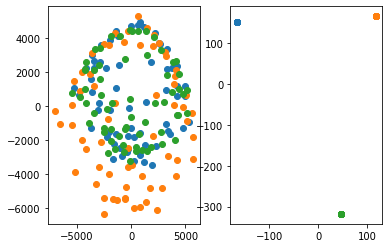

In [316]:
plt.subplot(121)
plt.scatter(X1p[0], X1p[1])
plt.scatter(X2p[0], X2p[1])
plt.scatter(X3p[0], X3p[1])

plt.subplot(122)
plt.scatter(X1pl[0], X1pl[1])
plt.scatter(X2pl[0], X2pl[1])
plt.scatter(X3pl[0], X3pl[1])